***

# Proyecto de innovación tecnológica en Inteligencia Artificial

***

### Proyecto RNN

#### Equipo:

1. Alvaro Acosta
2. Jhonatan Estrada
3. Cristian Gonzalez
4. Danny Martinez

In [1]:
# Importar las bibliotecas de Python requeridas.
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import warnings
import math

#from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_1samp, shapiro, kstest, anderson, probplot # Test One-Sample 1, Test de Normalidad 2
from statsmodels.stats.stattools import durbin_watson # Test de Independencia 3 (autocorrelación Durbin-Watson)
from statsmodels.stats.diagnostic import het_breuschpagan # Test de Homocedasticidad 4 (varianza constante Test Breusch-Pagan)
from numpy.polynomial.polynomial import Polynomial # Para generar polinomios

In [2]:
# Suprimir warnings.
warnings.simplefilter('ignore')

### Carga del Dataset

In [3]:
# Crear el Data Frame.
df = pd.read_csv('100_Batches_IndPenSim_V3.csv')
#df = pd.read_csv('100_Batches_IndPenSim_Statistics.csv')

# Imprimir los primeros cinco registros del DataFrame.
print('Encabezado del DataFrame:\n')
df.head(5)

Encabezado del DataFrame:



,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,210,209,208,207,206,205,204,203,202,201
0,0.2,30,100,8,0.0000,30.118,9.8335,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0.4,30,100,8,0.0000,51.221,18.1550,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0.6,30,100,8,0.0000,54.302,9.5982,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0.8,30,100,8,0.0000,37.816,4.3395,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,1.0,30,100,8,0.5181,18.908,1.1045,0.0001,0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [4]:
# Información de la estructura del df.
print('Estructura del DataFrame:\n')
df.shape

Estructura del DataFrame:



(113935, 2239)

Se visualiza la estructura del conjunto de datos, el cual consta de las variables predictoras $X$ (2238 variables) y la variable objetivo $Y$ (*Penicillin concentration(P:g/L)*), y contiene 113,935 registros.

Después de realizar un análisis detallado en conjunto con expertos en el área y del proceso, se definieron las siguientes variables que se consideran importantes y significativas en el proceso de producción de penicilina. Este análisis permitió identificar las variables más relevantes en función de su influencia directa en los resultados del proceso, así como su viabilidad para ser monitoreadas y controladas con sensores blandos. Las variables seleccionadas serán utilizadas como insumos principales inicialmente en el EDA y en el desarrollo de un modelo de Redes Neuronales Recurrentes (RNN) que buscará optimizar el rendimiento del proceso, las variables clave son:

- Time (h)
- Aeration rate (Fg:L/h)
- Agitator RPM (RPM:RPM)
- Sugar feed rate (Fs:L/h)
- Acid flow rate (Fa:L/h)
- Base flow rate (Fb:L/h)
- Heating/cooling water flow rate (Fc:L/h)
- Heating water flow rate (Fh:L/h)
- Water for injection/dilution (Fw:L/h)
- Air head pressure (pressure:bar)
- Dumped broth flow (Fremoved:L/h)
- Substrate concentration (S:g/L)
- Dissolved oxygen concentration (DO2:mg/L)
- Penicillin concentration (P:g/L)
- Vessel Volume (V:L)
- Vessel Weight (Wt:Kg)
- pH (pH:pH)
- Temperature (T:K)
- Generated heat (Q:kJ)
- Carbon dioxide percent in off-gas (CO2outgas:%)
- PAA flow (Fpaa:PAA flow (L/h))
- PAA concentration offline (PAA_offline:PAA (g L^{-1}))
- Oil flow (Foil:L/hr)
- NH₃ concentration offline (NH3_offline:NH3 (g L^{-1}))
- Oxygen Uptake Rate (OUR:(g min^{-1}))
- Oxygen in percent in off-gas (O2:O2 (%))
- Offline Penicillin concentration (P_offline:P(g L^{-1}))
- Offline Biomass concentration (X_offline:X(g L^{-1}))
- Carbon evolution rate (CER:g/h)
- Ammonia shots (NH3_shots:kgs)
- Viscosity (Viscosity_offline:centPoise)
- Fault reference (Fault_ref:Fault ref)
- 0 - Recipe driven 1 - Operator controlled (Control_ref:Control ref)
- 1 - No Raman spec
- 1 - Raman spec recorded
- 2 - PAT control (PAT_ref:PAT ref)
- Batch reference (Batch_ref:Batch ref)
- Batch ID

In [5]:
# Definir la lista de las columnas a seleccionar del dataset.
df_columns = [
    'Temperature(T:K)',
    'pH(pH:pH)',
    'Dissolved oxygen concentration(DO2:mg/L)',
    'Sugar feed rate(Fs:L/h)',
    'Substrate concentration(S:g/L)',
    'Oil flow(Foil:L/hr)',
    'Ammonia shots(NH3_shots:kgs)',
    'Oxygen in percent in off-gas(O2:O2  (%))',
    'carbon dioxide percent in off-gas(CO2outgas:%)',
    'Penicillin concentration(P:g/L)',
    ' 1-Raman spec recorded',
    '2-PAT control(PAT_ref:PAT ref)',
    'Batch reference(Batch_ref:Batch ref)',
    'Batch ID'
]

df = df[df_columns]

In [6]:
# Verificar si existen datos vacíos o faltantes en el DataFrame.
print('Cantidad de datos vacíos o faltantes DataFrame:\n')
df.isna().sum()

Cantidad de datos vacíos o faltantes DataFrame:



Temperature(T:K)                                  0
pH(pH:pH)                                         0
Dissolved oxygen concentration(DO2:mg/L)          0
Sugar feed rate(Fs:L/h)                           0
Substrate concentration(S:g/L)                    0
Oil flow(Foil:L/hr)                               0
Ammonia shots(NH3_shots:kgs)                      0
Oxygen in percent in off-gas(O2:O2  (%))          0
carbon dioxide percent in off-gas(CO2outgas:%)    0
Penicillin concentration(P:g/L)                   0
 1-Raman spec recorded                            0
2-PAT control(PAT_ref:PAT ref)                    0
Batch reference(Batch_ref:Batch ref)              0
Batch ID                                          0
dtype: int64

In [7]:
# Verificar si las columnas tienen valores únicos.
print(df.nunique())

Temperature(T:K)                                    393
pH(pH:pH)                                          3990
Dissolved oxygen concentration(DO2:mg/L)          11087
Sugar feed rate(Fs:L/h)                              25
Substrate concentration(S:g/L)                    64531
Oil flow(Foil:L/hr)                                   9
Ammonia shots(NH3_shots:kgs)                          1
Oxygen in percent in off-gas(O2:O2  (%))           3095
carbon dioxide percent in off-gas(CO2outgas:%)    28416
Penicillin concentration(P:g/L)                   56258
 1-Raman spec recorded                              100
2-PAT control(PAT_ref:PAT ref)                      100
Batch reference(Batch_ref:Batch ref)                  2
Batch ID                                          47361
dtype: int64


In [8]:
# Visualización del data frame con variables definidas
df

,Temperature(T:K),pH(pH:pH),Dissolved oxygen concentration(DO2:mg/L),Sugar feed rate(Fs:L/h),Substrate concentration(S:g/L),Oil flow(Foil:L/hr),Ammonia shots(NH3_shots:kgs),Oxygen in percent in off-gas(O2:O2 (%)),carbon dioxide percent in off-gas(CO2outgas:%),Penicillin concentration(P:g/L),1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID
0,298.22,6.4472,14.711,8,0.95749,22,0,0.19595,0.089514,1.017800e-25,1,1,0,0.0
1,298.17,6.4932,14.699,8,1.00460,22,0,0.20390,0.101760,1.000000e-03,1,1,0,0.0
2,298.14,6.5425,14.686,8,1.04980,22,0,0.20575,0.105800,9.993400e-04,1,1,0,0.0
3,298.11,6.5753,14.661,8,1.09420,22,0,0.20602,0.108190,9.987400e-04,1,1,0,0.0
4,298.09,6.5825,14.633,8,1.13700,22,0,0.20589,0.110300,9.982100e-04,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113930,297.89,6.5085,13.385,80,72.70800,23,0,0.19996,1.204400,5.656700e+00,100,100,1,43854.0
113931,298.07,6.5080,13.388,80,72.77400,23,0,0.20002,1.204100,5.649000e+00,100,100,1,44814.0
113932,297.98,6.5040,13.390,80,72.84200,23,0,0.20006,1.203800,5.641400e+00,100,100,1,44273.0
113933,297.88,6.4987,13.390,80,72.91000,23,0,0.20006,1.203400,5.633900e+00,100,100,1,44733.0


Al construir un modelo de redes neuronales recurrentes (RNN), el resultado de nunique() permite identificar qué variables aportan variabilidad suficiente para el entrenamiento del modelo. A partir de los resultados obtenidos, se puede interpretar lo siguiente.

1. Columnas con un único valor (como *Agitator RPM(RPM:RPM)*, *Ammonia shots(NH3_shots:kgs)*) no ofrecen ninguna variabilidad temporal y deberían ser eliminadas, ya que no contribuyen a la predicción.

2. Columnas con baja variabilidad (como *Air head pressure(pressure:bar)* con solo 6 valores únicos) pueden no ser relevantes para el modelo, ya que las RNN dependen de datos con una variabilidad más rica para capturar patrones temporales significativos.

3. Columnas con alta variabilidad (como *Aeration rate(Fg:L/h)*, *Sugar feed rate(Fs:L/h)*) son más valiosas para entrenar la RNN, ya que proporcionan datos diversos que pueden ayudar a modelar relaciones temporales y dinámicas complejas.

En resumen, para construir un modelo robusto de RNN, se deben priorizar las columnas con alta variabilidad y excluir aquellas con valores constantes o baja variabilidad.

In [9]:
# Obtener los estadísticos descriptivos del DataFrame.
print('Estadísticos descriptivos del DataFrame:\n')
df.describe()

Estadísticos descriptivos del DataFrame:



,Temperature(T:K),pH(pH:pH),Dissolved oxygen concentration(DO2:mg/L),Sugar feed rate(Fs:L/h),Substrate concentration(S:g/L),Oil flow(Foil:L/hr),Ammonia shots(NH3_shots:kgs),Oxygen in percent in off-gas(O2:O2 (%)),carbon dioxide percent in off-gas(CO2outgas:%),Penicillin concentration(P:g/L),1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID
count,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.000000,113935.0,113935.000000,113935.000000,1.139350e+05,113935.000000,113935.000000,113935.000000,113935.000000
mean,298.026489,6.496565,12.569647,76.663764,4.079817,26.352789,0.0,0.191458,1.444042,1.433395e+01,50.402466,50.402466,0.101154,89307.003616
std,0.197513,0.065676,1.498680,25.680134,13.303517,4.954933,0.0,0.004718,0.498955,9.932453e+00,28.862140,28.862140,0.301534,47765.751082
min,296.840000,5.395700,1.000000,2.000000,0.000006,22.000000,0.0,0.129500,0.075425,3.694700e-26,1.000000,1.000000,0.000000,0.000000
25%,297.950000,6.493200,11.639000,72.000000,0.001025,23.000000,0.0,0.188860,1.225900,5.531250e+00,26.000000,26.000000,0.000000,47016.500000
50%,297.990000,6.500900,12.636000,80.000000,0.001644,23.000000,0.0,0.191180,1.596300,1.438000e+01,50.000000,50.000000,0.000000,89699.000000
75%,298.040000,6.508600,13.614000,90.000000,0.003003,30.000000,0.0,0.193660,1.757300,2.268750e+01,76.000000,76.000000,0.000000,129390.000000
max,302.180000,6.766400,16.508000,150.000000,115.270000,35.000000,0.0,0.227510,7.121400,3.618300e+01,100.000000,100.000000,1.000000,194630.000000


El análisis descriptivo de los datos revela una gran variabilidad en varios de los parámetros de operación, lo que es crucial para la construcción de modelos predictivos, como una red neuronal recurrente. En primer lugar, se observa que el tiempo de proceso (*Time (h)*) varía significativamente entre 0.2 y 290 horas, indicando que el sistema ha operado durante períodos muy largos, lo que podría reflejar la complejidad y duración de los procesos involucrados.

En cuanto a las tasas de flujo, la tasa de aeración (*Aeration rate(Fg:L/h)*) tiene un valor promedio de 65.25 L/h, lo que sugiere una aeración constante durante las operaciones. Por otro lado, la velocidad de agitación (*Agitator RPM(RPM:RPM)*) es uniforme a 100 RPM, lo que indica que este parámetro se mantiene constante a lo largo del proceso. Sin embargo, los flujos de ácido (*Acid flow rate(Fa:L/h)*) y base (*Base flow rate(Fb:L/h)*) muestran un comportamiento distinto: el flujo de ácido es generalmente bajo o nulo en la mayoría de los registros, mientras que el flujo de base presenta una mayor variabilidad, con valores que alcanzan hasta 225 L/h. Esto sugiere que los flujos de base pueden ser más sensibles a las condiciones operativas y, por lo tanto, más relevantes para el modelo.

En cuanto a las concentraciones de los componentes críticos, la concentración de oxígeno disuelto (*Dissolved oxygen concentration(DO2:mg/L)*) muestra una amplia dispersión, con valores que varían desde niveles muy bajos hasta 16.51 mg/L. Esta variabilidad en la concentración de oxígeno puede ser crucial, ya que es un parámetro clave en procesos biológicos como la fermentación. La concentración de penicilina (*Penicillin concentration(P:g/L)*), que es la variable objetivo, tiene una media de 14.33 g/L con una desviación estándar considerable de 9.93, lo que indica fluctuaciones importantes en su producción.

En cuanto a la generación de calor (*Generated heat(Q:kJ)*), los valores promedio son relativamente altos (279.07 kJ), con una notable dispersión. Esto podría estar relacionado con los cambios en la actividad metabólica o las reacciones de producción, sugiriendo que el calor generado podría ser un factor influyente en el proceso. Asimismo, el porcentaje de dióxido de carbono en los gases de escape (*carbon dioxide percent in off-gas(CO2outgas:%)*) también muestra variabilidad, con un promedio de 1.44%, lo que sugiere fluctuaciones en la tasa de respiración o fermentación.

Finalmente, el análisis revela que ciertos parámetros presentan valores faltantes en un número significativo de registros, especialmente en variables como la viscosidad (*Viscosity(Viscosity_offline:centPoise)*) y la concentración de NH3 (*NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))*). Estos valores ausentes podrían requerir técnicas de imputación o estrategias específicas de tratamiento de datos para evitar que interfieran en la construcción del modelo. Además, algunas variables, como la velocidad de agitación (*Agitator RPM(RPM:RPM)*), son constantes, lo que puede indicar que no tienen un impacto directo en las predicciones del modelo, a menos que se incluyan para representar la estabilidad del proceso.

En resumen, el análisis indica que el modelo debe enfocarse en las variables con mayor variabilidad, como los flujos de base, la concentración de oxígeno y la producción de penicilina, mientras maneja adecuadamente las columnas con valores faltantes. Además, se debe considerar la posible eliminación de variables constantes si no aportan valor predictivo al modelo.

In [11]:
# Calcular la varianza de las variables del DataFrame.
print('Varianza de las variables del DataFrame:\n')
df.var()

Varianza de las variables del DataFrame:



Time (h)                                                              4.487728e+03
Aeration rate(Fg:L/h)                                                 1.366611e+02
Agitator RPM(RPM:RPM)                                                 0.000000e+00
Sugar feed rate(Fs:L/h)                                               6.594693e+02
Acid flow rate(Fa:L/h)                                                3.055746e-01
Base flow rate(Fb:L/h)                                                2.022545e+03
Heating/cooling water flow rate(Fc:L/h)                               1.166888e+04
Heating water flow rate(Fh:L/h)                                       2.523080e+03
Water for injection/dilution(Fw:L/h)                                  2.421182e+04
Air head pressure(pressure:bar)                                       1.802814e-02
Dumped broth flow(Fremoved:L/h)                                       8.120264e+05
Substrate concentration(S:g/L)                                        1.769836e+02
Diss

In [12]:
# Calcular la covarianza del DataFrame.
print('Covarianza de las variables del DataFrame:\n')
df.cov()

Covarianza de las variables del DataFrame:



,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),...,Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),1- No Raman spec,1-Raman spec recorded,2-PAT control(PAT_ref:PAT ref),Batch reference(Batch_ref:Batch ref),Batch ID
Time (h),4.487728e+03,528.143915,0.0,756.918162,3.663426,-814.337188,-3.016968e+03,950.489466,2.405159e+03,0.898530,...,19.258032,0.0,1527.650676,-0.102101,0.125509,-0.535460,-19.625953,-19.625953,0.104698,2.767423e+06
Aeration rate(Fg:L/h),5.281439e+02,136.661119,0.0,182.455077,0.110312,-15.875618,-4.946503e+02,54.887009,2.758227e+02,0.794068,...,4.971724,0.0,220.102399,-0.101229,0.039750,0.032893,-3.154088,-3.154088,-0.078513,3.997858e+05
Agitator RPM(RPM:RPM),0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
Sugar feed rate(Fs:L/h),7.569182e+02,182.455077,0.0,659.469273,-0.139139,314.431980,-3.779509e+02,6.812459,7.467542e+02,1.516257,...,8.178382,0.0,253.159784,-0.202474,0.453170,-0.046684,-25.702827,-25.702827,-0.378104,5.844686e+05
Acid flow rate(Fa:L/h),3.663426e+00,0.110312,0.0,-0.139139,0.305575,-4.161620,-3.483969e-01,2.085290,-1.387827e+00,-0.003863,...,-0.008076,0.0,1.471675,0.002021,0.006945,-0.017931,0.107606,0.107606,0.012595,6.132371e+01
Base flow rate(Fb:L/h),-8.143372e+02,-15.875618,0.0,314.431980,-4.161620,2022.544927,1.015698e+03,-264.915521,5.278203e+02,0.976270,...,1.056154,0.0,-352.574812,-0.226258,-0.717392,2.772918,-2.006712,-2.006712,-1.412666,-2.429112e+05
Heating/cooling water flow rate(Fc:L/h),-3.016968e+03,-494.650300,0.0,-377.950932,-0.348397,1015.698365,1.166888e+04,-748.150168,-4.180856e+03,-3.130306,...,-24.613085,0.0,-1151.263163,-0.092830,0.756818,-2.097517,122.522564,122.522564,3.025365,-2.449691e+06
Heating water flow rate(Fh:L/h),9.504895e+02,54.887009,0.0,6.812459,2.085290,-264.915521,-7.481502e+02,2523.079654,5.213526e+02,-0.732763,...,0.521721,0.0,307.279985,0.020979,0.183324,-0.757778,28.762064,28.762064,0.934727,3.865403e+05
Water for injection/dilution(Fw:L/h),2.405159e+03,275.822698,0.0,746.754184,-1.387827,527.820296,-4.180856e+03,521.352642,2.421182e+04,8.389196,...,16.963670,0.0,853.327615,-0.440991,0.228562,-0.003624,11.551406,11.551406,0.094724,1.319788e+06
Air head pressure(pressure:bar),8.985302e-01,0.794068,0.0,1.516257,-0.003863,0.976270,-3.130306e+00,-0.732763,8.389196e+00,0.018028,...,0.041051,0.0,0.964261,0.000272,-0.000081,0.000190,0.004392,0.004392,-0.000052,9.707336e+02


In [ ]:
# Exportar tabla de covarianza
df.cov().to_excel("tabla_covarianza.xlsx", index=True)
print("Tabla exportada")

Tabla exportada


**Análisis de Covarianzas entre Variables Operativas del Proceso Industrial**

Covarianza positiva:

El análisis de la matriz de covarianzas revela las relaciones entre las variables importantes del proceso. La covarianza entre Time (h) y Aeration rate (Fg:L/h) es de 528,14, indicando una relación positiva entre el tiempo de operación y la tasa de aireación

la correlación de Aeration rate (Fg:L/h) con Sugar feed rate (Fs:L/h) (182,46) implica una interacción positiva, lo que podría reflejar la necesidad de mayor aireación para procesar altos niveles de alimentación de azúcar.

la covarianza entre Heating/cooling water flow rate (Fc:L/h) y Base flow rate (Fb:L/h) es 1015,70, lo que indica una relación positiva, Esto sugiere que a medida que aumenta el flujo de agua de calentamiento/refrigeración, también tiende a incrementarse el flujo de base, posiblemente debido a una interacción directa en la regulación térmica del proceso.

Por último, la covarianza entre Water for injection/dilution (Fw:L/h) y Heating water flow rate (Fh:L/h) es 521,35, lo que indica una relación positiva, 


Covarianza negativa:

la covarianza entre Time (h) y Base flow rate (Fb:L/h) es negativa con un valor de -814,34, lo que sugiere que el aumento del tiempo está asociado con una reducción en la tasa de flujo de base

La relación entre Heating/cooling water flow rate (Fc:L/h) y Time (h) es negativa (-3016,97), lo cual puede deberse a efectos contrapuestos en la dinámica térmica del sistema,


**Análisis de Covarianzas entre Variables Operativas del Proceso Industrial**

**Covarianzas positivas:**

*Time (h) y Aeration rate (Fg:L/h): 528,14*

Interpretación: Existe una relación positiva entre el tiempo de operación y la tasa de aireación. Esto sugiere que a medida que aumenta el tiempo de operación en el proceso, también aumenta la cantidad de aire proporcionado (tasa de aireación). Esto puede indicar que, a lo largo del tiempo, es necesario incrementar la aireación para mantener las condiciones óptimas de operación. Esta relación podría estar asociada con un proceso biológico o químico que requiere un suministro continuo de aire para asegurar una eficiencia adecuada durante un largo período de tiempo.

*Aeration rate (Fg:L/h) y Sugar feed rate (Fs:L/h): 182,46*

Interpretación: La relación positiva entre la tasa de aireación y la tasa de alimentación de azúcar sugiere que a medida que aumenta la cantidad de aire inyectado, también se incrementa la cantidad de azúcar alimentada al proceso. Esto puede ocurrir en procesos donde se requiere una mayor aireación para mantener o aumentar la actividad microbiana o de otro tipo que consume el azúcar. Esto es común en procesos de fermentación o biotecnología, donde el oxígeno y el azúcar son consumidos por los organismos para producir productos deseados, como alcohol o ácidos.

*Heating/cooling water flow rate (Fc:L/h) y Base flow rate (Fb:L/h): 1015,70*

Interpretación: Esta relación positiva indica que tanto el flujo de agua para calefacción/refrigeración como el flujo base aumentan juntos. Esto sugiere que un mayor flujo de agua destinado a regular la temperatura está asociado con un aumento en el flujo base del sistema. En términos prácticos, puede implicar que cuando se requiere ajustar la temperatura (ya sea aumentando o disminuyendo la cantidad de agua de calefacción/refrigeración), también se necesita ajustar el flujo base para mantener el equilibrio térmico o de presión en el sistema.

*Water for injection/dilution (Fw:L/h) y Heating water flow rate (Fh:L/h): 521,35*

Interpretación: Existe una relación positiva entre el flujo de agua para inyección/dilución y el flujo de agua de calefacción. Esto sugiere que cuando se incrementa la cantidad de agua utilizada para diluir o inyectar en el proceso, también se incrementa el agua utilizada para regulación térmica. Es posible que en un proceso de fabricación o tratamiento, se requiera un mayor flujo de agua tanto para diluir sustancias o para inyectar productos, mientras se mantiene constante la necesidad de regulación térmica para asegurar las condiciones ideales del proceso.

**Covarianzas negativas:**

*Time (h) y Base flow rate (Fb:L/h): -814,34*

Interpretación: La interpretación parece válida. Una relación negativa entre el tiempo de operación y el flujo base sugiere que, a medida que avanza el proceso, el flujo base disminuye. Esto podría ser parte de una estrategia de optimización o ajuste según las demandas operativas. Sin embargo, esta interpretación podría aclararse más si se tiene información sobre el tipo de proceso, por ejemplo, si el flujo base se ajusta para evitar el desperdicio de recursos a medida que el proceso avanza.

*Heating/cooling water flow rate (Fc:L/h) y Time (h): -3016,97*

Interpretación: Esta fuerte relación negativa sugiere que a medida que aumenta el tiempo de operación, disminuye el flujo de agua de calefacción/refrigeración. Esto podría ser indicativo de un proceso en el que, a lo largo del tiempo, la necesidad de ajustar la temperatura (a través de la calefacción o refrigeración) disminuye, tal vez porque el sistema ya ha alcanzado una temperatura estable o debido a una reducción en las variaciones térmicas durante la operación. Es posible que el proceso se estabilice con el tiempo, requiriendo menos ajustes térmicos conforme avanza la operación.

la falta de variación en Agitator RPM y Ammonia shots sugiere que ambos parámetros han sido establecidos y optimizados para el proceso, y se mantiene una operación constante sin la necesidad de realizar ajustes adicionales. Esto refleja un sistema estable y controlado que está funcionando de manera eficiente y no requiere intervención para ajustar estos dos parámetros a lo largo del tiempo.

**Análisis Univariado**

Para realizar un análisis de outliers mediante boxplots, es esencial identificar las variables con mayor variabilidad, ya que estas suelen ser más propensas a contener valores atípicos o comportamientos extremos que podrían influir significativamente en los resultados. En este caso, las variables seleccionadas presentan las mayores varianzas en la matriz de covarianza, lo que refleja una alta dispersión en sus datos. Este enfoque permite enfocarse en aquellas métricas con mayor relevancia para el proceso estudiado, como el peso y volumen del reactor (*Vessel Weight (Wt:Kg)* y *Vessel Volume (V:L)*), concentraciones químicas críticas (*PAA concentration offline (PAA_offline: PAA (g L⁻¹)*) y *NH₃ concentration offline (NH₃_offline: NH₃ (g L⁻¹)*), y factores operativos clave como los flujos de inyección de agua (*Water for injection/dilution (Fw:L/h)*), flujo de caldo descartado (*Dumped broth flow (Fremoved:L/h)*), y generación de calor (*Generated heat (Q:kJ)*). Además, se incluye el análisis de variables relacionadas con los flujos de calentamiento/enfriamiento del agua (*Heating/cooling water flow rate (Fc:L/h)*) y dimensiones de identificación y temporales como *Batch ID* y *Time (h)*. Analizar estas variables con boxplots permite detectar valores anómalos que podrían representar oportunidades de optimización o posibles puntos de mejora en el proceso.

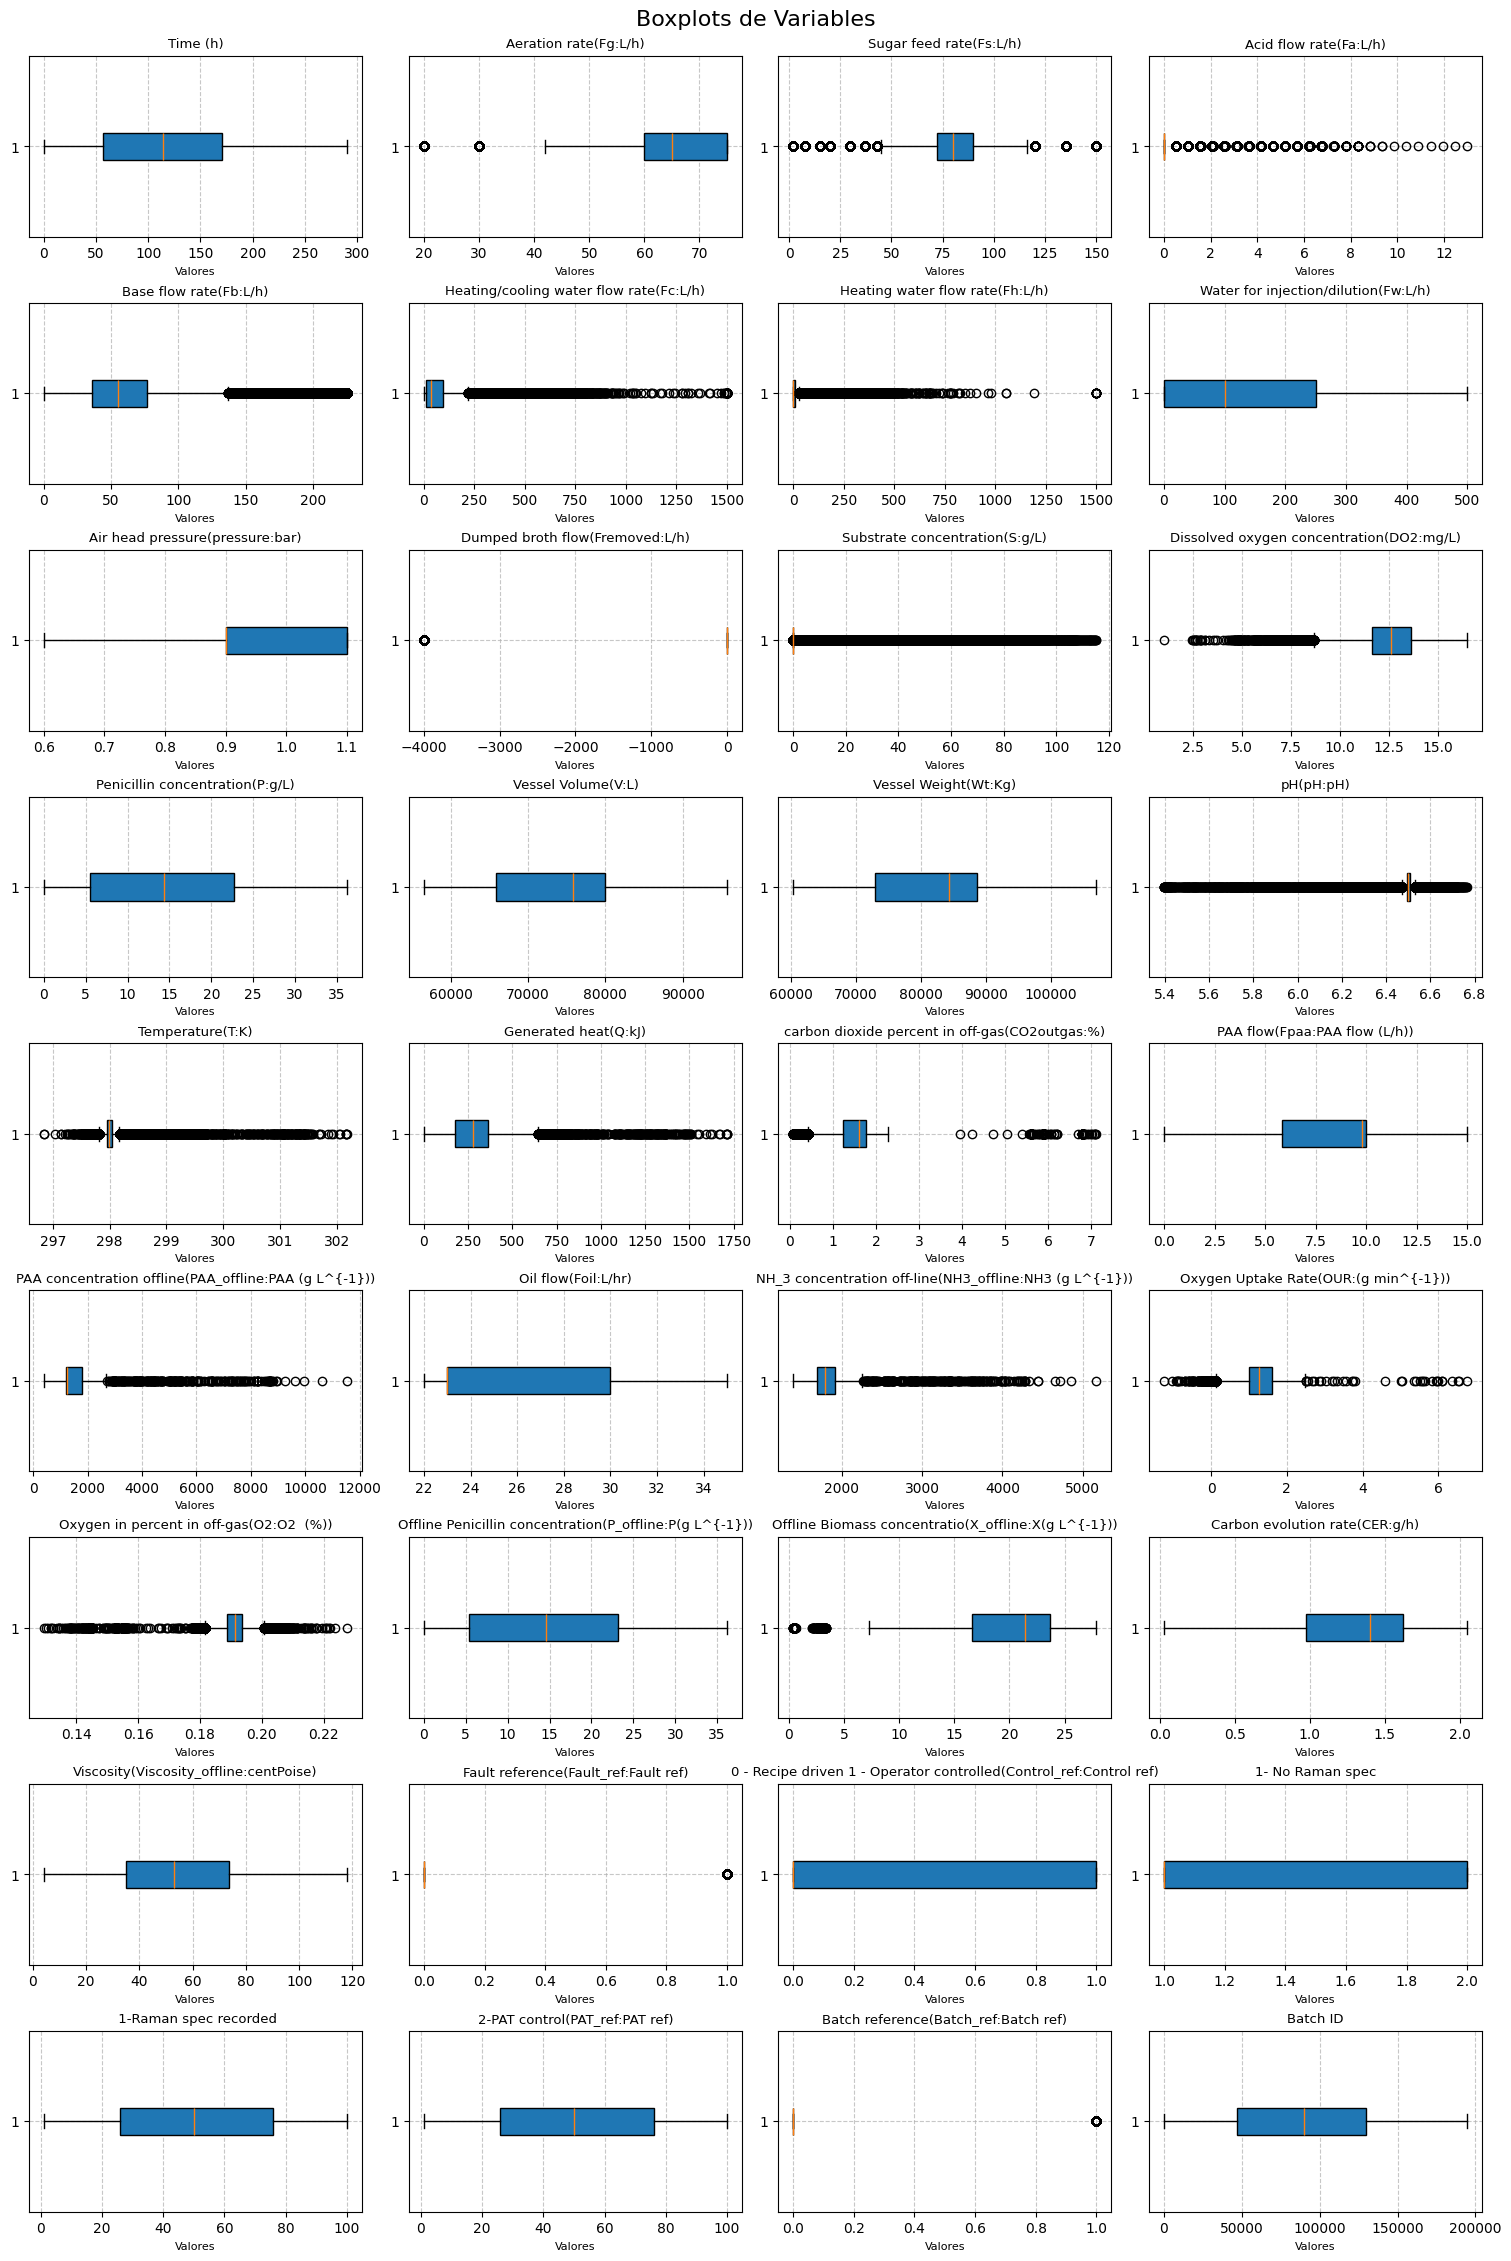

In [ ]:
variables_box = [
    'Time (h)', 'Aeration rate(Fg:L/h)', 'Sugar feed rate(Fs:L/h)',
    'Acid flow rate(Fa:L/h)', 'Base flow rate(Fb:L/h)',
    'Heating/cooling water flow rate(Fc:L/h)', 'Heating water flow rate(Fh:L/h)',
    'Water for injection/dilution(Fw:L/h)', 'Air head pressure(pressure:bar)',
    'Dumped broth flow(Fremoved:L/h)', 'Substrate concentration(S:g/L)',
    'Dissolved oxygen concentration(DO2:mg/L)', 'Penicillin concentration(P:g/L)',
    'Vessel Volume(V:L)', 'Vessel Weight(Wt:Kg)', 'pH(pH:pH)', 'Temperature(T:K)',
    'Generated heat(Q:kJ)', 'carbon dioxide percent in off-gas(CO2outgas:%)',
    'PAA flow(Fpaa:PAA flow (L/h))', 'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
    'Oil flow(Foil:L/hr)', 'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
    'Oxygen Uptake Rate(OUR:(g min^{-1}))', 'Oxygen in percent in off-gas(O2:O2  (%))',
    'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
    'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
    'Carbon evolution rate(CER:g/h)', 'Viscosity(Viscosity_offline:centPoise)',
    'Fault reference(Fault_ref:Fault ref)',
    '0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)',
    '1- No Raman spec', ' 1-Raman spec recorded', '2-PAT control(PAT_ref:PAT ref)',
    'Batch reference(Batch_ref:Batch ref)', 'Batch ID'
]

# Configuración para mostrar 3 gráficos por fila
num_columns = 4
num_rows = math.ceil(len(variables_box) / num_columns)


fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 2.5), constrained_layout=True)

# Aplanar el arreglo de ejes (para iterar fácilmente)
axes = axes.flatten()

# Graficar cada variable
for i, var in enumerate(variables_box):
    if var in df.columns:  # Verificar si la columna existe en el DataFrame
        axes[i].boxplot(df[var].dropna(), vert=False, patch_artist=True)
        axes[i].set_title(var, fontsize=9.5)
        axes[i].set_xlabel('Valores', fontsize=8)
        axes[i].grid(True, linestyle='--', alpha=0.7)
    else:
        # Si la variable no está en el DataFrame, ocultar el subplot
        axes[i].axis('off')

# Ocultar ejes sobrantes (si no hay suficientes variables)
for j in range(len(variables_box), len(axes)):
    axes[j].axis('off')

plt.suptitle('Boxplots de Variables', fontsize=16)
plt.show()

### Análisis Boxplot

Para el analisis de este tipo de gráfico, se toman 4 variables que servirán para ejemplicar un analisis detallado posterior en este proceso, vale la pena mencionar que este tipo de gráfico permite identificar de manera visual la forma en la que los datos se distribuyen facilitando la identficación de valores atípicos

1. Aeration rate (g/L/h)
La variable presenta una distribución concentrada entre 60 y 75 g/L/h, con una mediana cercana a 65. Sin embargo, se identifican varios valores atípicos por debajo de 40 g/L/h, lo que podría reflejar interrupciones en el suministro de aire o ajustes específicos en ciertas etapas del proceso. Estos outliers inferiores podrían impactar el rendimiento si la aireación es un factor crítico en el sistema.

2. Sugar feed rate (L/h)
La mayoría de los valores de esta variable se encuentran entre 48 y 120 L/h, aproximadamente con una mediana cercana a 80. Se observan numerosos outliers superiores que superan los 120 L/h, llegando hasta 150, y algunos inferiores cercanos a 0 L/h. Los valores altos podrían deberse a un exceso en la dosificación de azúcar, mientras que los bajos podrían indicar interrupciones en la alimentación o necesidades reducidas en ciertas fases del proceso.

3. Acid flow rate (Fa: L/h)
La variable muestra una distribución compacta con valores concentrados entre 0 y aproximadamente 2 L/h. No se observa una caja o rango intercuartil definido en el boxplot, lo que indica que los datos están distribuidos de manera uniforme o que podrían ser valores únicos a lo largo del eje y el rango parece reflejar un control consistente en el flujo de ácido durante el proceso.

4. Heating/cooling water flow rate (Fc: L/h)
La variable presenta una distribución concentrada en valores bajos, con un rango intercuartil (IQR) aproximadamente entre 0 y 250 L/h. Sin embargo, se observa una cantidad considerable de valores atípicos superiores que se extienden hasta los 1500 L/h, lo que indica eventos de alto flujo fuera de lo habitual. Estos outliers podrían estar relacionados con picos en la demanda térmica durante ciertas fases del proceso, ajustes en los sistemas de control o posibles anomalías operativas. Se recomienda analizar las condiciones específicas en las que ocurren estos valores extremos para determinar si representan un comportamiento esperado o una desviación del estándar.





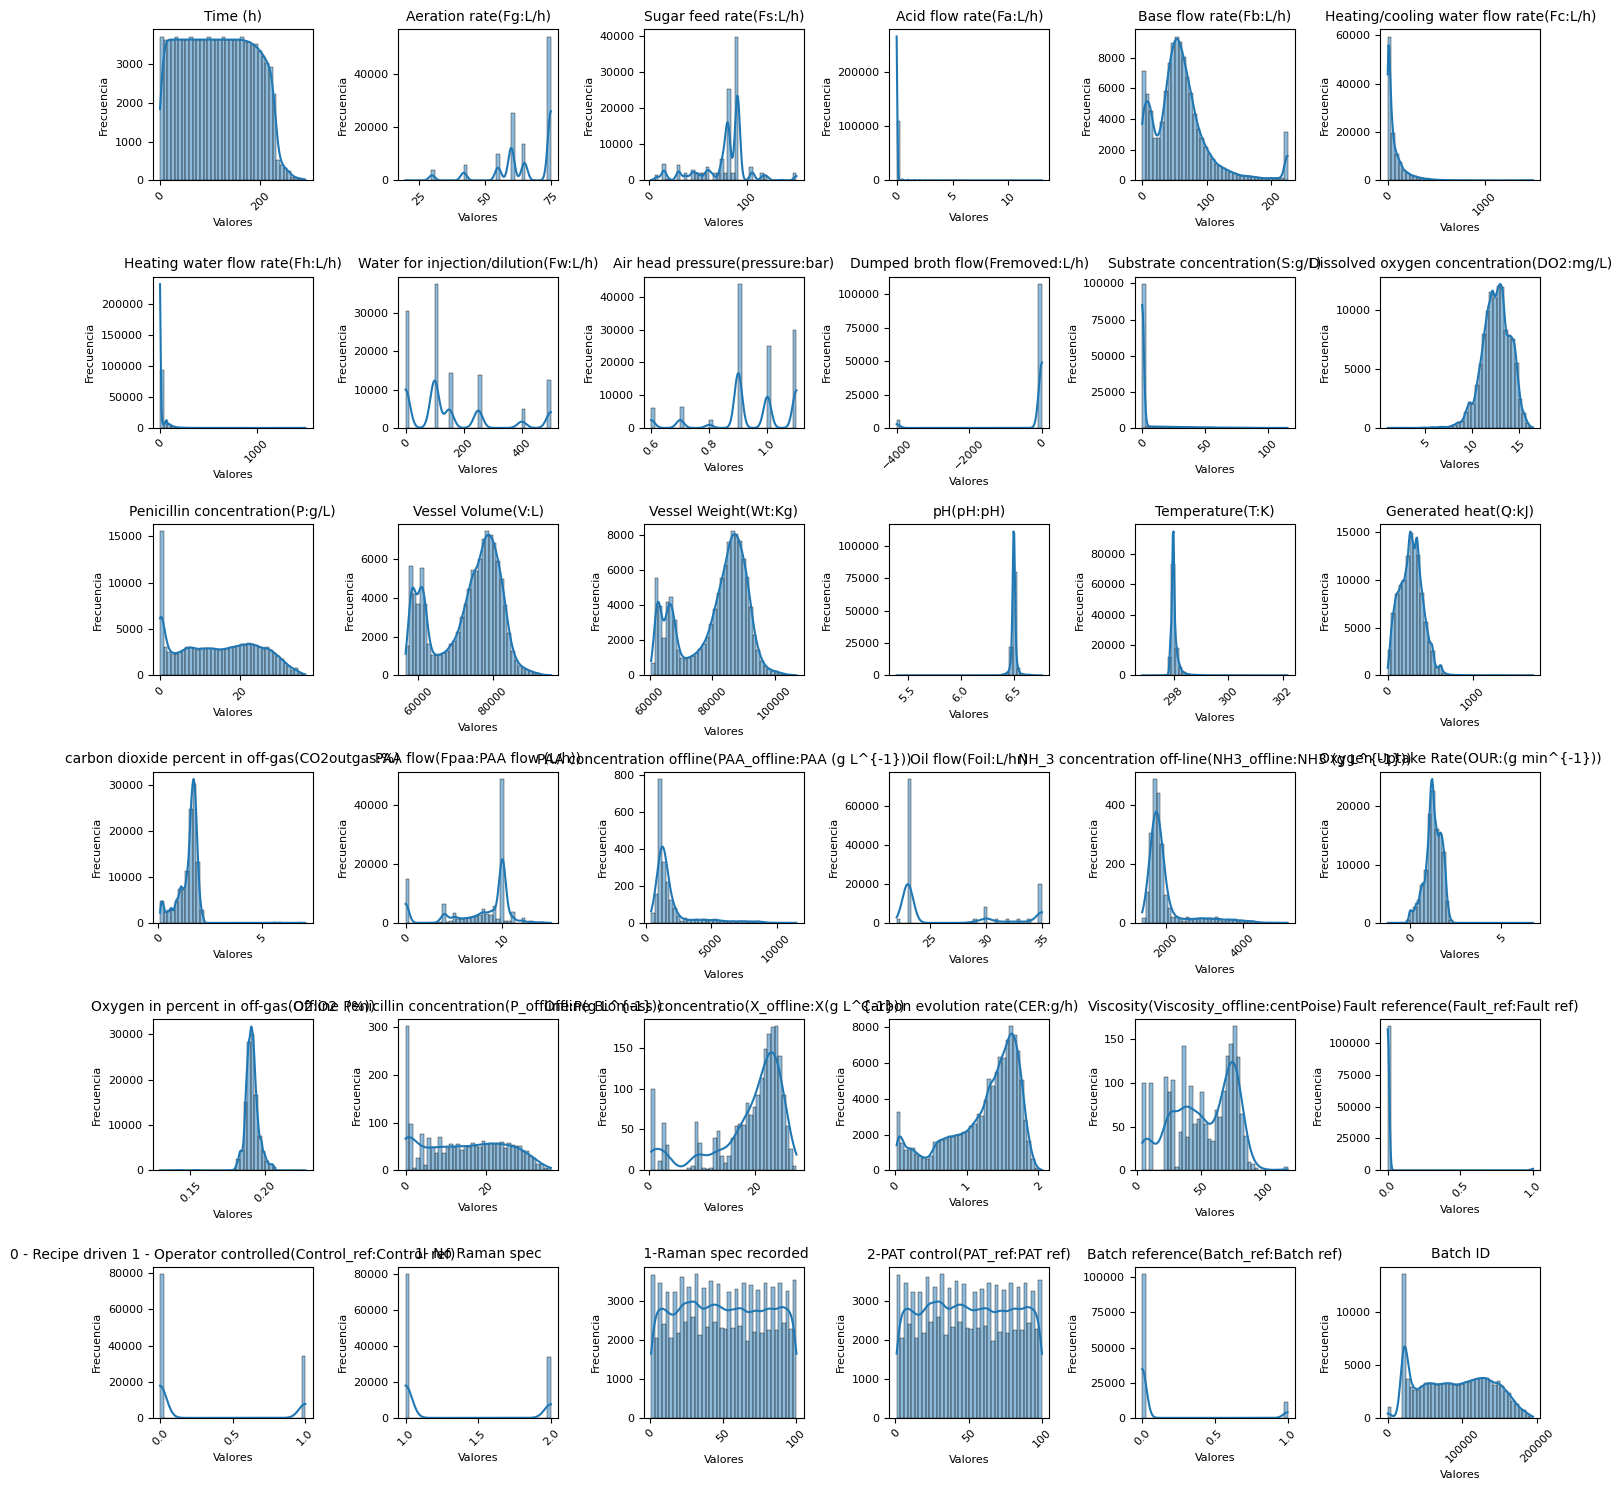

In [ ]:
# Graficar histogramas para cada variable
plt.figure(figsize=(15, 15))
for i, variable in enumerate(variables):
    plt.subplot(6, 6, i + 1)  # Ajustar el número de filas y columnas (aquí 6x6)
    sns.histplot(df[variable], kde=True, bins=40)  # Histogramas con densidad
    plt.title(variable, fontsize=10)
    plt.xlabel('Valores', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


**Análisis de correlaciones**

A continuación un análisis de correlación para las variables relevantes, con el objetivo de evaluar las relaciones entre ellas y comprender mejor cómo influyen entre sí dentro del proceso. Es importante señalar que las variables Agitator RPM y Ammonia shots no se incluirán en este análisis, ya que no presentan variación significativa en la matriz de datos.


In [17]:
# Definir las variables (más relevantes) para el cálculo de correlación.
df_correlation = df[[
    'Time (h)',
    'Aeration rate(Fg:L/h)',
    'Sugar feed rate(Fs:L/h)',
    'Acid flow rate(Fa:L/h)',
    'Base flow rate(Fb:L/h)',
    'Heating/cooling water flow rate(Fc:L/h)',
    'Heating water flow rate(Fh:L/h)',
    'Water for injection/dilution(Fw:L/h)',
    'Air head pressure(pressure:bar)',
    'Dumped broth flow(Fremoved:L/h)',
    'Substrate concentration(S:g/L)',
    'Dissolved oxygen concentration(DO2:mg/L)',
    'Penicillin concentration(P:g/L)',
    'Vessel Volume(V:L)',
    'Vessel Weight(Wt:Kg)',
    'pH(pH:pH)',
    'Temperature(T:K)',
    'Generated heat(Q:kJ)',
    'carbon dioxide percent in off-gas(CO2outgas:%)',
    'PAA flow(Fpaa:PAA flow (L/h))',
    'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
    'Oil flow(Foil:L/hr)',
    'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
    'Oxygen Uptake Rate(OUR:(g min^{-1}))',
    'Oxygen in percent in off-gas(O2:O2  (%))',
    'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
    'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
    'Carbon evolution rate(CER:g/h)',
    'Viscosity(Viscosity_offline:centPoise)',
    'Fault reference(Fault_ref:Fault ref)',
    '0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)',
    '1- No Raman spec',
    ' 1-Raman spec recorded',
    '2-PAT control(PAT_ref:PAT ref)',
    'Batch reference(Batch_ref:Batch ref)',
    'Batch ID'
]]

In [18]:
# Cálculo de la correlación del DataFrame utilizando el método de Pearson.
print('======================================================')
print('=========== Correlación - Método de Pearson ==========')
print('======================================================')
print(df_correlation.corr(method = 'pearson'))

=========== Correlación - Método de Pearson ==========
                                                    Time (h)  \
Time (h)                                            1.000000   
Aeration rate(Fg:L/h)                               0.674398   
Sugar feed rate(Fs:L/h)                             0.439986   
Acid flow rate(Fa:L/h)                              0.098927   
Base flow rate(Fb:L/h)                             -0.270297   
Heating/cooling water flow rate(Fc:L/h)            -0.416910   
Heating water flow rate(Fh:L/h)                     0.282468   
Water for injection/dilution(Fw:L/h)                0.230737   
Air head pressure(pressure:bar)                     0.099895   
Dumped broth flow(Fremoved:L/h)                    -0.167832   
Substrate concentration(S:g/L)                      0.387363   
Dissolved oxygen concentration(DO2:mg/L)           -0.205547   
Penicillin concentration(P:g/L)                     0.870176   
Vessel Volume(V:L)                               

In [ ]:
### Exportar tabla correlación Pearson
df_correlation.corr(method = 'pearson').to_excel("corrpearson.xlsx", index=True)
print("Tabla exportada corr pearson")

Tabla exportada corr pearson


In [32]:
### Exportar tabla correlaciones de Pearson >0,8 y -0,8
pearson_corr = df_correlation.corr(method='pearson')

# Extraer correlaciones fuertes (mayores a 0.8 o menores a -0.8) sin incluir la diagonal
strong_corr = pearson_corr.where(~np.eye(pearson_corr.shape[0], dtype=bool))
strong_corr = strong_corr[(strong_corr > 0.8) | (strong_corr < -0.8)]

# Transformar la matriz en un DataFrame
strong_corr_table = strong_corr.stack().reset_index()
strong_corr_table.columns = ['Variable 1', 'Variable 2', 'Índice de correlación Pearson']

# Exportar a un archivo Excel
strong_corr_table.to_excel("correlaciones_Pearson_fuertes.xlsx", index=False)
print("Archivo Excel exportado exitosamente.")

Archivo Excel exportado exitosamente.


In [19]:
# Cálculo de la correlación del DataFrame utilizando el método de Kendall.
print('\n======================================================')
print('=========== Correlación - Método de Kendall ==========')
print('======================================================')
print(df_correlation.corr(method = 'kendall'))


=========== Correlación - Método de Kendall ==========
                                                    Time (h)  \
Time (h)                                            1.000000   
Aeration rate(Fg:L/h)                               0.537766   
Sugar feed rate(Fs:L/h)                             0.270452   
Acid flow rate(Fa:L/h)                              0.048770   
Base flow rate(Fb:L/h)                             -0.193145   
Heating/cooling water flow rate(Fc:L/h)            -0.276980   
Heating water flow rate(Fh:L/h)                     0.447436   
Water for injection/dilution(Fw:L/h)                0.416741   
Air head pressure(pressure:bar)                    -0.191954   
Dumped broth flow(Fremoved:L/h)                    -0.138486   
Substrate concentration(S:g/L)                     -0.207143   
Dissolved oxygen concentration(DO2:mg/L)           -0.153841   
Penicillin concentration(P:g/L)                     0.764741   
Vessel Volume(V:L)                              

In [ ]:
### Exportar tabla correlación kendall
df_correlation.corr(method = 'kendall').to_excel("corrkedall.xlsx", index=True)
print("Tabla exportada corr kendall")

Tabla exportada corr kendall


In [ ]:
### Exportar tabla correlaciones de kendall >0,8 y -0,8
kendall_corr = df_correlation.corr(method='kendall')

# Extraer correlaciones fuertes (mayores a 0.8 o menores a -0.8) sin incluir la diagonal
strong_corr = kendall_corr.where(~np.eye(kendall_corr.shape[0], dtype=bool))
strong_corr = strong_corr[(strong_corr > 0.8) | (strong_corr < -0.8)]

# Transformar la matriz en un DataFrame
strong_corr_table = strong_corr.stack().reset_index()
strong_corr_table.columns = ['Variable 1', 'Variable 2', 'Índice de correlación kendall']

# Exportar a un archivo Excel
strong_corr_table.to_excel("correlaciones_kendall_fuertes.xlsx", index=False)
print("Archivo Excel exportado exitosamente.")

Archivo Excel exportado exitosamente.


In [20]:
# Cálculo de la correlación del DataFrame utilizando el método de spearman.
print('\n======================================================')
print('=========== Correlación - Método de Spearman =========')
print('======================================================')
print(df_correlation.corr(method = 'spearman'))


=========== Correlación - Método de Spearman =========
                                                    Time (h)  \
Time (h)                                            1.000000   
Aeration rate(Fg:L/h)                               0.695444   
Sugar feed rate(Fs:L/h)                             0.359401   
Acid flow rate(Fa:L/h)                              0.060098   
Base flow rate(Fb:L/h)                             -0.285698   
Heating/cooling water flow rate(Fc:L/h)            -0.421361   
Heating water flow rate(Fh:L/h)                     0.612635   
Water for injection/dilution(Fw:L/h)                0.517216   
Air head pressure(pressure:bar)                    -0.118560   
Dumped broth flow(Fremoved:L/h)                    -0.169539   
Substrate concentration(S:g/L)                     -0.193879   
Dissolved oxygen concentration(DO2:mg/L)           -0.235270   
Penicillin concentration(P:g/L)                     0.877274   
Vessel Volume(V:L)                              

In [ ]:
### Exportar tabla correlación spearman
df_correlation.corr(method = 'spearman').to_excel("corrspearman.xlsx", index=True)
print("Tabla exportada corr spearman")

Tabla exportada corr spearman


In [ ]:
### Exportar tabla correlaciones de spearman >0,8 y -0,8
spearman_corr = df_correlation.corr(method='spearman')

# Extraer correlaciones fuertes (mayores a 0.8 o menores a -0.8) sin incluir la diagonal
strong_corr = spearman_corr.where(~np.eye(spearman_corr.shape[0], dtype=bool))
strong_corr = strong_corr[(strong_corr > 0.8) | (strong_corr < -0.8)]

# Transformar la matriz en un DataFrame
strong_corr_table = strong_corr.stack().reset_index()
strong_corr_table.columns = ['Variable 1', 'Variable 2', 'Índice de correlación spearman']

# Exportar a un archivo Excel
strong_corr_table.to_excel("correlaciones_spearman_fuertes.xlsx", index=False)
print("Archivo Excel exportado exitosamente.")

Archivo Excel exportado exitosamente.


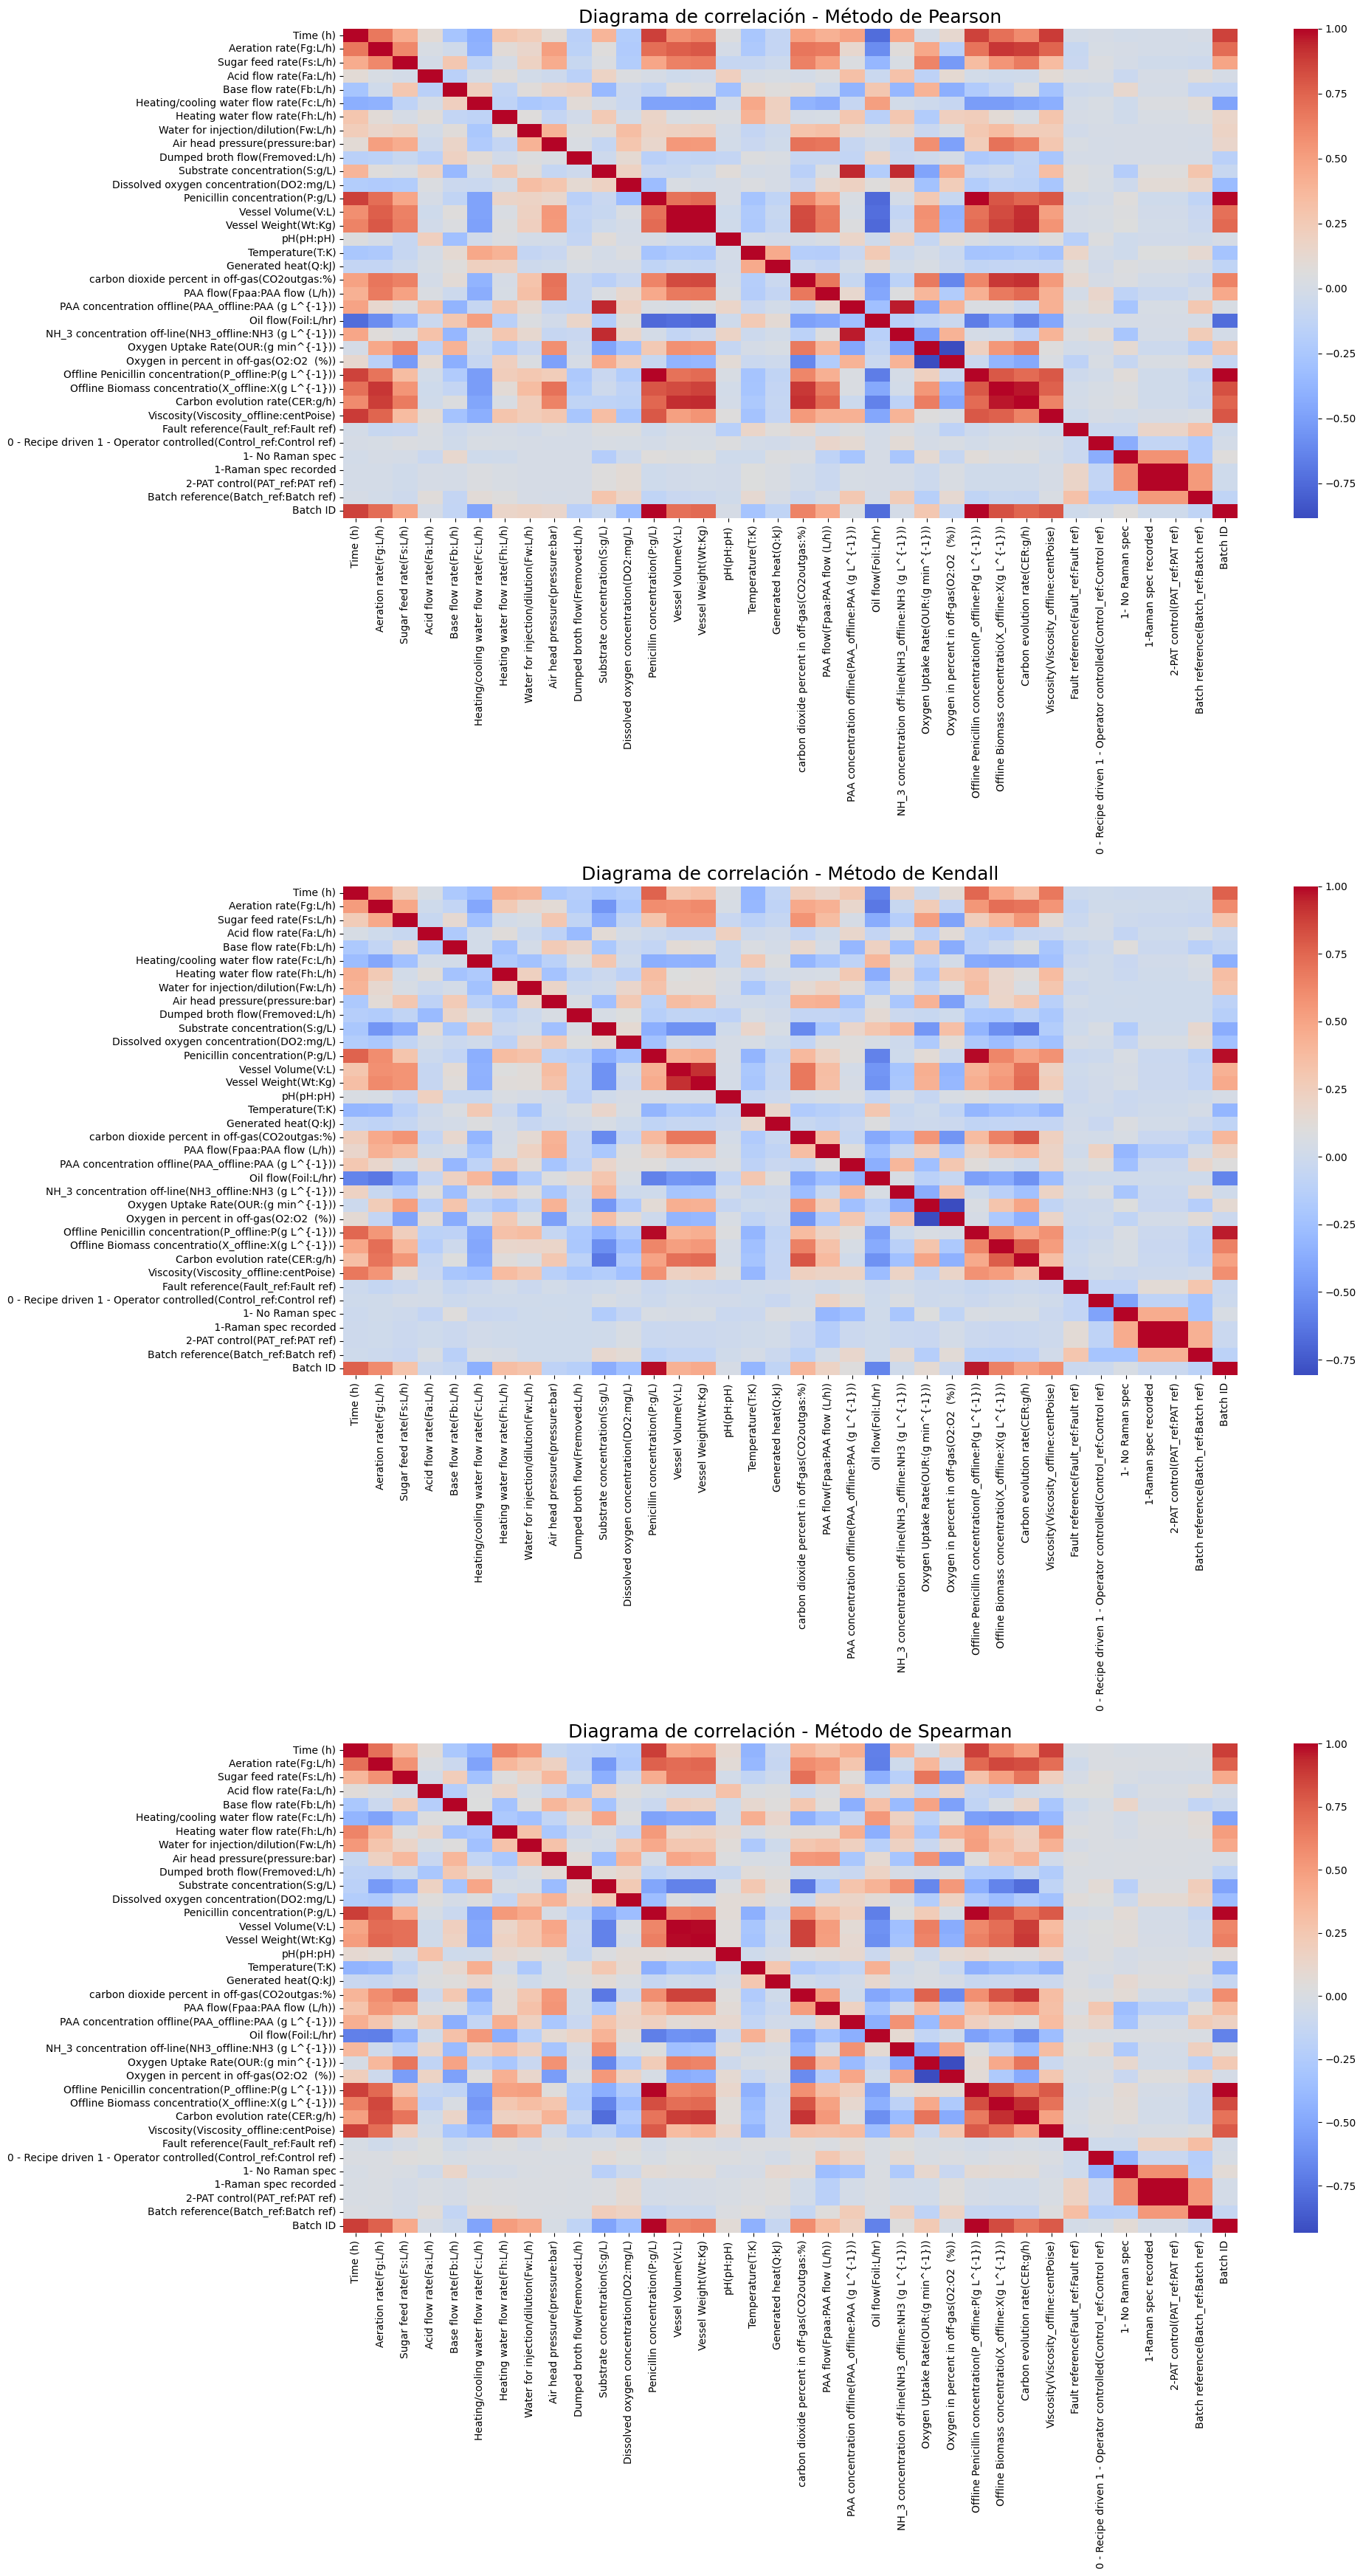

In [48]:
# Gráfico del mapa de calor de la matriz de correlación utilizando los métodos de Pearson, Kendall y Spearman.
plt.figure(figsize = (20, 35))

plt.subplot(3, 1, 1)
plt.title('Diagrama de correlación - Método de Pearson', fontsize = 18)
sns.heatmap(df_correlation.corr(method = 'pearson'), annot = False, cmap = 'coolwarm', fmt = '.3f')

plt.subplot(3, 1, 2)
plt.title('Diagrama de correlación - Método de Kendall', fontsize = 18)
sns.heatmap(df_correlation.corr(method = 'kendall'), annot = False, cmap = 'coolwarm', fmt = '.3f')

plt.subplot(3, 1, 3)
plt.title('Diagrama de correlación - Método de Spearman', fontsize = 18)
sns.heatmap(df_correlation.corr(method = 'spearman'), annot = False, cmap = 'coolwarm', fmt = '.3f')

plt.tight_layout()
plt.show()

El análisis de correlación utilizando los métodos de Pearson, Kendall y Spearman muestra patrones consistentes respecto a la relación entre las variables del proceso de fermentación y la concentración de penicilina (*Penicillin concentration (P:g/L)*). En los tres métodos, la variable **Tiempo (*Time (h)*)** exhibe una correlación positiva significativa, con valores de 0.87 en Pearson, 0.76 en Kendall y 0.87 en Spearman. Esto reafirma que el tiempo es un factor fundamental en el incremento de la concentración de penicilina a lo largo del proceso.

La **tasa de aireación (*Aeration rate (Fg:L/h)*)** también presenta una relación positiva destacada, con coeficientes de 0.71, 0.60 y 0.75 en Pearson, Kendall y Spearman, respectivamente. Esto sugiere que un adecuado suministro de oxígeno es esencial para favorecer el crecimiento del hongo y la síntesis de penicilina. La **concentración de biomasa (*Offline Biomass concentration (X_offline:X(g L^{-1}))*)** muestra una correlación fuerte y consistente, con valores de 0.79 en Pearson, 0.63 en Kendall y 0.82 en Spearman. Esto confirma que el desarrollo celular eficiente es un determinante clave en la productividad del proceso.

La **tasa de evolución de carbono (*Carbon evolution rate (CER:g/h)*)** presenta correlaciones moderadamente altas, con valores de 0.74, 0.49 y 0.68 en los métodos de Pearson, Kendall y Spearman, respectivamente. Esto resalta su relevancia en los mecanismos metabólicos asociados a la síntesis de penicilina. Asimismo, la **viscosidad (*Viscosity (centPoise)*)** mantiene valores significativos en los tres métodos, con coeficientes de 0.79, 0.58 y 0.73 en Pearson, Kendall y Spearman, respectivamente, indicando que las propiedades físicas del medio influyen en el proceso de producción.

La **masa del recipiente (*Vessel Weight (Wt:Kg)*)** exhibe una correlación positiva significativa, con valores de 0.72, 0.46 y 0.63 en Pearson, Kendall y Spearman, respectivamente. Esto sugiere que el peso del recipiente, que puede estar relacionado con el volumen o condiciones internas del proceso, tiene un impacto positivo en la concentración de penicilina. Por el contrario, la **tasa de flujo de aceite (*Oil flow (Foil:L/hr)*)** presenta una correlación negativa consistente, con valores de -0.75, -0.57 y -0.71 en Pearson, Kendall y Spearman. Esto indica que un mayor flujo de aceite puede interferir con las condiciones ideales para la producción de penicilina, posiblemente alterando la composición o las dinámicas internas del sistema.

Por otro lado, variables como las tasas de flujo ácido (*Acid flow rate (Fa:L/h)*) y flujo base (*Base flow rate (Fb:L/h)*) presentan correlaciones bajas o despreciables en todos los métodos, con valores cercanos a 0.01 y -0.12 respectivamente. Esto sugiere un impacto mínimo en la concentración de penicilina. Estas variables podrían no requerir un control estricto dentro de las condiciones estándar del proceso.

En conjunto, los tres métodos de correlación coinciden en identificar las variables **Tiempo (*Time (h)*)**, **Tasa de aireación (*Aeration rate (Fg:L/h)*)**, **Concentración de biomasa (*Offline Biomass concentration (X_offline:X(g L^{-1}))*)**, **Tasa de evolución de carbono (*Carbon evolution rate (CER:g/h)*)**, **Viscosidad (*Viscosity (centPoise)*)**, **Masa del recipiente (*Vessel Weight (Wt:Kg)*)**, y **Tasa de flujo de aceite (*Oil flow (Foil:L/hr)*)** como factores importantes en el proceso. Esta consistencia entre métodos proporciona una base sólida para priorizar estas variables en modelos predictivos como redes neuronales recurrentes. Las variables clave permitirán capturar las dinámicas temporales y metabólicas del proceso, mejorando la precisión del modelo y proporcionando insights valiosos para la optimización de la producción.

Como parte del análisis exploratorio de datos (EDA), se han evaluado las correlaciones entre las variables del proceso de fermentación y la concentración de penicilina (*Penicillin concentration (P:g/L)*), utilizando los métodos de Pearson, Kendall y Spearman. Este análisis tiene como objetivo identificar las variables más relevantes que impactan en la producción de penicilina, proporcionando una base sólida para construir un modelo de redes neuronales recurrentes (RNN). Este modelo se utilizará para pronosticar con precisión la concentración de penicilina, aprovechando las dinámicas temporales y metabólicas del proceso.

**En consecuencia, el modelo de redes neuronales recurrentes (RNN) será inicialmente entrenado utilizando la totalidad de las variables definidas, permitiendo un análisis integral que capture tanto las dinámicas temporales como las interacciones complejas entre las variables operativas del proceso. Esta estrategia garantizará que ninguna relación potencialmente significativa sea omitida en las etapas iniciales del modelado, proporcionando una línea base para comparar y optimizar el modelo en fases posteriores.**

### Modelamiento

In [ ]:
# Descarga de libreria Tensorflow
! pip install tensorflow

                                              0.0/390.0 MB ? eta -:--:--
                                              0.0/390.0 MB ? eta -:--:--
                                              0.0/390.0 MB 1.3 MB/s eta 0:05:05
                                              0.1/390.0 MB 1.4 MB/s eta 0:04:30
                                              0.3/390.0 MB 2.1 MB/s eta 0:03:03
                                              0.6/390.0 MB 3.5 MB/s eta 0:01:53
                                              0.9/390.0 MB 4.5 MB/s eta 0:01:26
                                              1.3/390.0 MB 5.0 MB/s eta 0:01:18
                                              1.6/390.0 MB 5.4 MB/s eta 0:01:12
                                              2.1/390.0 MB 6.4 MB/s eta 0:01:01
                                              2.2/390.0 MB 5.5 MB/s eta 0:01:11
                                              2.2/390.0 MB 5.4 MB/s eta 0:01:13
                                              2.2/390.

### Imputación de variables con valores nulos por su media

In [27]:
# Imputación de variables con valores nulos por su media
df['PAA concentration offline(PAA_offline:PAA (g L^{-1}))'] = df['PAA concentration offline(PAA_offline:PAA (g L^{-1}))'].fillna(df['PAA concentration offline(PAA_offline:PAA (g L^{-1}))'].mean())

df['NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))'] = df['NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))'].fillna(df['NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))'].mean())

df['Offline Penicillin concentration(P_offline:P(g L^{-1}))'] = df['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].fillna(df['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].mean())

df['Offline Biomass concentratio(X_offline:X(g L^{-1}))'] = df['Offline Biomass concentratio(X_offline:X(g L^{-1}))'].fillna(df['Offline Biomass concentratio(X_offline:X(g L^{-1}))'].mean())

df['Viscosity(Viscosity_offline:centPoise)'] = df['Viscosity(Viscosity_offline:centPoise)'].fillna(df['Viscosity(Viscosity_offline:centPoise)'].mean())

In [28]:
# Verificar si existen datos vacíos o faltantes en el DataFrame.
print('Cantidad de datos vacíos o faltantes DataFrame:\n')
df.isna().sum()

Cantidad de datos vacíos o faltantes DataFrame:



Time (h)                                                              0
Aeration rate(Fg:L/h)                                                 0
Agitator RPM(RPM:RPM)                                                 0
Sugar feed rate(Fs:L/h)                                               0
Acid flow rate(Fa:L/h)                                                0
Base flow rate(Fb:L/h)                                                0
Heating/cooling water flow rate(Fc:L/h)                               0
Heating water flow rate(Fh:L/h)                                       0
Water for injection/dilution(Fw:L/h)                                  0
Air head pressure(pressure:bar)                                       0
Dumped broth flow(Fremoved:L/h)                                       0
Substrate concentration(S:g/L)                                        0
Dissolved oxygen concentration(DO2:mg/L)                              0
Penicillin concentration(P:g/L)                                 

In [ ]:
df.dtypes

Time (h)                                                              float64
Aeration rate(Fg:L/h)                                                   int64
Agitator RPM(RPM:RPM)                                                   int64
Sugar feed rate(Fs:L/h)                                                 int64
Acid flow rate(Fa:L/h)                                                float64
Base flow rate(Fb:L/h)                                                float64
Heating/cooling water flow rate(Fc:L/h)                               float64
Heating water flow rate(Fh:L/h)                                       float64
Water for injection/dilution(Fw:L/h)                                    int64
Air head pressure(pressure:bar)                                       float64
Dumped broth flow(Fremoved:L/h)                                         int64
Substrate concentration(S:g/L)                                        float64
Dissolved oxygen concentration(DO2:mg/L)                        

### Modelo de Red Neuronal Recurrente (RNN)

El modelo propuesto corresponde a una red neuronal recurrente (RNN), específicamente que utiliza una capa LSTM (Long Short-Term Memory) para pronosticar la concentración de penicilina en un bioproceso. 

El objetivo principal es predecir la concentración de penicilina (Penicillin concentration (P:g/L)) en función de una serie de variables del proceso medidas a lo largo del tiempo.

A continuación, se describen las etapas para la elaboración del modelo:

*Preprocesamiento de los Datos*

1. Variables de Entrada (X):

Las variables de entrada son todas las columnas del conjunto de datos definido, excluyendo la columna de la concentración de penicilina (Penicillin concentration (P:g/L)) que es la variable objetivo. Las variables de entrada incluyen aspectos como la tasa de aireación (Aeration rate (Fg:L/h)), la velocidad del agitador (Agitator RPM (RPM:RPM)), la concentración de oxígeno disuelto (Dissolved oxygen concentration (DO2:mg/L)), entre muchas otras que reflejan las condiciones del proceso de producción.

2. Normalización de Datos:

Para que el modelo no se vea afectado por las escalas de las variables de entrada (por ejemplo, el tiempo en horas tiene una escala mucho mayor que otras características), se normalizan las variables  mediante el uso de un MinMaxScaler. Este normaliza todas las variables en el rango [0, 1], lo cual es especialmente importante para las redes neuronales, que son sensibles a las magnitudes absolutas de las características.

3. Creación de Secuencias:

Debido a que se trabaja con datos temporales, se transforman los datos en secuencias temporales de longitud time_steps. Esto significa que las observaciones se dividen en fragmentos que contienen información sobre el estado del proceso durante un número determinado de horas anteriores. En este caso, se selecciona un tamaño de ventana de 3 horas. Con esto se busca que, dado el estado del proceso en las últimas 3 horas, el modelo podrá predecir la concentración de penicilina en la siguiente hora.

Este preprocesamiento es crucial para los modelos RNN, ya que les permite aprender de las dependencias temporales y no solo de los valores de las variables en momentos específicos.


*Construcción del Modelo*

1. Capa LSTM:

La capa principal del modelo, es una capa LSTM, que es capaz de capturar dependencias temporales a largo plazo. LSTM es una variante de las redes neuronales recurrentes (RNN) que resuelve el problema del desvanecimiento del gradiente, permitiendo que el modelo mantenga información de eventos pasados por un número mayor de pasos de tiempo.

La capa LSTM del modelo tiene 50 unidades (o "neuronas"), lo que significa que la capa tendrá 50 vectores de estado oculto que ayudan a la red a aprender patrones complejos en las secuencias de datos.

El parámetro return_sequences=False se configura para que la capa LSTM solo pase una salida final, ya que solo se requiere la predicción de la concentración de penicilina al final de la secuencia de entrada (es decir, para la última hora de la ventana de tiempo).

2. Capa de Dropout:

Para evitar el sobreajuste (overfitting), se adiciona una capa de Dropout con una tasa de 0.2. Esto significa que durante el entrenamiento, el modelo "apaga" aleatoriamente el 20% de las neuronas en la capa LSTM, lo que ayuda a que el modelo generalice mejor y no dependa demasiado de patrones específicos de los datos de entrenamiento.

3. Capa densa:

La capa final es una capa densa con una sola neurona, que produce la predicción de la concentración de penicilina para el siguiente paso de tiempo. Dado que se está tratando de predecir una variable continua, esta capa no tiene una función de activación (es decir, no usamos activation='relu' o sigmoid'), lo que permite que el modelo genere cualquier valor real.

*Compilación y Entrenamiento*

El optimizador utilizado es Adam, que es uno de los optimizadores más utilizados en redes neuronales debido a su capacidad para manejar problemas de optimización no lineales de manera eficiente.

La función de pérdida es el error cuadrático medio (Mean Squared Error, MSE), ya que corresponde a un problema de regresión.

Durante el entrenamiento, el modelo ajusta sus parámetros para minimizar la pérdida, es decir, para mejorar la predicción de la concentración de penicilina a lo largo del tiempo, basándose en las secuencias de datos de entrada.

*Evaluación del Modelo*

Una vez entrenado, el modelo se evalúa en un conjunto de prueba, y el rendimiento se mide utilizando el MSE, MAE y R^2. Además, se grafican las predicciones frente a los valores reales para observar visualmente qué tan bien el modelo predice la concentración de penicilina.

*Resultados*

Finalmente, después del entrenamiento, el modelo genera predicciones que se comparan con los valores reales de la concentración de penicilina en el conjunto de prueba. La gráfica resultante evidencia cómo las predicciones del modelo siguen de cerca la variabilidad de los valores reales, reflejando su capacidad para capturar patrones relevantes. Además, al comparar los resultados del modelo con un Baseline, se puede evaluar qué tan significativamente supera el modelo a una predicción basada en el azar, validando así su desempeño.

A continuación, se describe la elección de los hiperámetros usados en el modelo

1. *time_steps = 3 (Ventanas de Tiempo)*

Este parámetro indica cuántas horas anteriores se utilizarán como entrada para predecir la siguiente hora. Se utiliza una ventana de 3 horas como punto de partida, ya que las concentraciones de penicilina pueden depender de los procesos previos durante algunas horas. Generalmente, en series temporales, una ventana más grande puede proporcionar más contexto, pero también aumenta la complejidad del modelo.

2. *units = 50 en la capa LSTM*

Este parámetro define cuántas unidades o "celdas" tendrá la capa LSTM. Cada unidad tiene su propia memoria para aprender patrones temporales. Se define un valor de 50 el cual es común en problemas donde las series temporales tienen una complejidad media. Si el número de unidades es demasiado pequeño, el modelo puede no aprender las relaciones complejas en los datos. Si es demasiado grande, el modelo podría sobreajustarse y entrenar demasiado tiempo sin mejorar en datos no vistos.

3. *Dropout = 0.2*

El Dropout se utiliza para evitar el sobreajuste, donde durante el entrenamiento, aleatoriamente se desactivan algunas neuronas para que el modelo no dependa de ninguna de ellas demasiado. Se define un valor de 0.2, lo que significa que el 20% de las neuronas serán desactivadas aleatoriamente durante cada paso de entrenamiento. Este es un valor común en problemas de aprendizaje profundo.

4. *epochs = 50*

El número de épocas indica cuántas veces todo el conjunto de entrenamiento pasará por el modelo. Se definen 50 épocas, lo cual es un valor que es considerado intermedio. La cantidad de épocas depende del tamaño de los datos y del rendimiento del modelo.

5. *batch_size = 16*

El batch size determina cuántas muestras serán procesadas antes de actualizar los pesos del modelo. Se define un tamaño de 16 el cual se considera común para este tipo de modelos y generalmente funciona bien. Un tamaño pequeño (por ejemplo, 16 o 32) puede hacer que el modelo aprenda más rápido, mientras que un tamaño mayor puede estabilizar el entrenamiento, pero hacerlo más lento.

6. *optimizer = 'adam'*

El optimizador Adam es uno de los más populares para entrenar redes neuronales, especialmente con datos ruidosos o problemas complejos de series temporales, como los que podrían estar presentes en procesos industriales (como la concentración de penicilina).

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,651 (68.95 KB)

 Trainable params: 17,651 (68.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 29.2189 - val_loss: 1.5255
Epoch 2/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 2.5749 - val_loss: 1.4706
Epoch 3/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 2.2955 - val_loss: 1.3397
Epoch 4/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 2.0748 - val_loss: 1.2584
Epoch 5/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.8786 - val_loss: 1.2601
Epoch 6/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.7548 - val_loss: 1.1048
Epoch 7/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.6212 - val_loss: 1.3802
Epoch 8/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.6458 - val_loss: 1.3681
Epoch 9/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.4679 - val_loss: 1.5171
Epoch 10/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.4339 - val_loss: 1.1243
Epoch 11/50
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1.4710 - val_loss: 1.2166
Epoch 12/50
5697/5

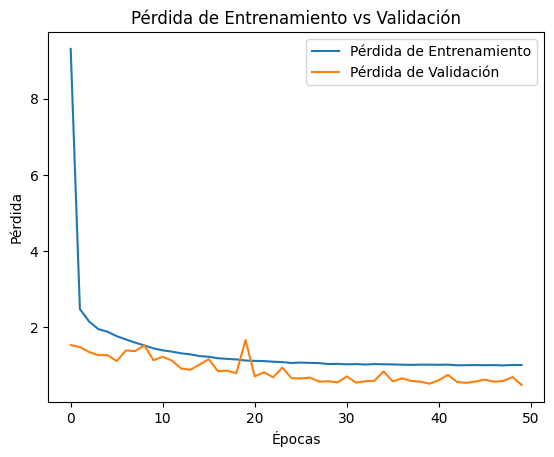

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


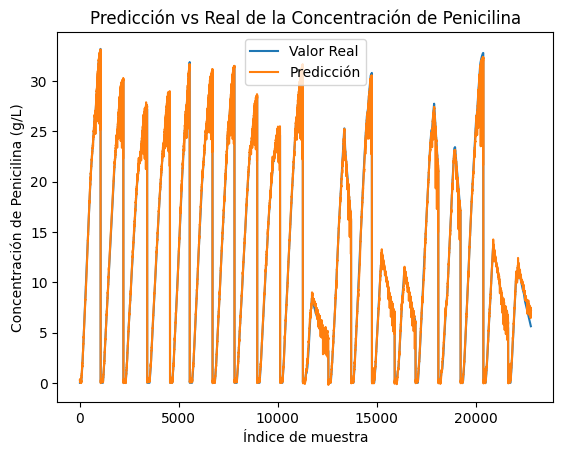

MSE: 0.4761755693623026


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# Seleccionar las características (X) y la variable objetivo (y)
X = df.drop(columns=['Penicillin concentration(P:g/L)'])  # Usamos todas las columnas excepto la variable objetivo
y = df['Penicillin concentration(P:g/L)']  # Variable objetivo (output)



# Normalizar las características, incluida la variable `Time (h)`
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Preprocesar los datos para convertirlos en secuencias de tiempo (ventanas de tiempo)
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Usar las últimas 'time_steps' horas como entrada para predecir la siguiente
time_steps = 3  # Por ejemplo, usar 3 horas para predecir la siguiente
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

# Dividir los datos en entrenamiento y prueba (sin aleatorización, debido a la naturaleza temporal)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Construir el modelo LSTM
model = Sequential()

# Capa LSTM: 'units' define cuántas unidades de memoria tendrá la capa LSTM
# 'return_sequences=False' ya que estamos solo prediciendo el siguiente valor
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Capa de Dropout: Para evitar sobreajuste, un valor de 0.2 es común
model.add(Dropout(0.2))

# Capa densa (fully connected): De una sola neurona ya que es una predicción continua
model.add(Dense(units=1))

# Compilación del modelo con el optimizador Adam (uno de los mejores para este tipo de problemas)
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Graficar el progreso de la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento vs Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Graficar predicciones vs valor real
plt.plot(y_test, label='Valor Real')
plt.plot(y_pred, label='Predicción')
plt.title('Predicción vs Real de la Concentración de Penicilina')
plt.xlabel('Índice de muestra')
plt.ylabel('Concentración de Penicilina (g/L)')
plt.legend()
plt.show()

# Calcular el Error Cuadrático Medio (MSE) como métrica de evaluación
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')


La gráfica *"Pérdida de Entrenamiento vs Validación"* muestra que la pérdida de entrenamiento disminuye rápidamente en las primeras épocas, estabilizándose alrededor de la época 10, lo que indica que el modelo LSTM aprende a ajustar sus parámetros de manera efectiva. La pérdida de validación es consistentemente más baja y estable que la de entrenamiento, lo que sugiere una buena capacidad de generalización y ausencia de sobreajuste, gracias al uso de técnicas como Dropout. Aunque se observan pequeñas fluctuaciones en la curva de validación, estas son normales y reflejan la variabilidad en los datos de prueba. En general, el modelo demuestra un desempeño equilibrado, indicando que está bien entrenado para predecir la concentración de penicilina de manera confiable.

La gráfica de *"Predicción vs Real de la Concentración de Penicilina"* muestra una buena alineación entre los valores predichos por el modelo de RNN  y los valores reales, lo que indica que el modelo logra capturar de manera precisa las tendencias y variaciones en los datos. La superposición casi completa entre las dos curvas refleja la capacidad del modelo para aprender los patrones temporales de la concentración de penicilina en función de las variables de entrada. Aunque no se observan desviaciones significativas, es importante evaluar métricas adicionales, como el error cuadrático medio (MSE), el error absoluto medio (MAE) y el coeficiente de determinación ($R^2$) para confirmar la precisión y consistencia del modelo en datos no vistos. Esta gráfica valida que el modelo es robusto y confiable para el propósito de predicción en este contexto

A continuación se analizan los resultados de las métricas de evaluación del modelo.

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Realizar predicciones en el conjunto de prueba y_pred = model.predict(X_test) # Calcular el Error Cuadrático Medio (MSE) 
mse = mean_squared_error(y_test, y_pred) # Calcular el Error Absoluto Medio (MAE) 
mae = mean_absolute_error(y_test, y_pred) # Calcular el Coeficiente de Determinación (R²) 
r2 = r2_score(y_test, y_pred) # Imprimir los resultados de las métricas 
print(f'Error Cuadrático Medio (MSE): {mse}') 
print(f'Error Absoluto Medio (MAE): {mae}') 
print(f'Coeficiente de Determinación (R²): {r2}')


Error Cuadrático Medio (MSE): 0.4761755693623026
Error Absoluto Medio (MAE): 0.2614253470958436
Coeficiente de Determinación (R²): 0.9949912801656712


### Análisis de las métricas de evaluación

*Error Cuadrático Medio (MSE): 0.4762*

El MSE mide la magnitud promedio de los errores al cuadrado entre las predicciones y los valores reales. Un valor más bajo indica que el modelo predice con mayor precisión. En este caso, un MSE de 0.4762 sugiere que los errores de predicción son pequeños, lo que indica un buen desempeño general. Sin embargo, debido a que el error está en unidades cuadradas, es menos intuitivo comparado con el MAE.

*Error Absoluto Medio (MAE): 0.2614*

El MAE mide el error promedio en las mismas unidades que la variable objetivo (en este caso, gramos por litro de penicilina). Un valor de 0.2614 significa que, en promedio, el modelo se desvía aproximadamente 0.26 g/L de la concentración real de penicilina. Este es un nivel de error relativamente bajo, mostrando que el modelo tiene un buen nivel de precisión en las predicciones.

*Coeficiente de Determinación (R²): 0.9950*

El R² indica qué tan bien las predicciones del modelo explican la variabilidad de la concentración real de penicilina. Un valor de 0.9950 sugiere que el 99.5% de la variación en la concentración de penicilina está siendo explicada por el modelo. Esto es un excelente ajuste, lo que demuestra que el modelo captura de manera efectiva las dinámicas del proceso.

Conclusión

Los resultados reflejan un modelo muy bien ajustado, que realiza predicciones precisas sobre la concentración de penicilina en función de las variables clave del proceso de fermentación. Sin embargo, es importante evaluar el modelo con datos nuevos o no vistos para confirmar que este nivel de precisión se mantenga y que el modelo no esté sobreajustado a los datos de entrenamiento.


### Cáculo del Baseline para comparar con resultados del modelo

In [38]:
# Crear un modelo base (Baseline) que use los valores anteriores como predicción 
y_baseline_pred = y_test[:-1] # Usamos todos los valores excepto el último 
y_baseline_real = y_test[1:] # Compararemos con todos los valores excepto el primero # Calcular métricas del modelo base 
baseline_mse = mean_squared_error(y_baseline_real, y_baseline_pred) 
baseline_mae = mean_absolute_error(y_baseline_real, y_baseline_pred) 
baseline_r2 = r2_score(y_baseline_real, y_baseline_pred) # Imprimir métricas del modelo base 
print(f'Modelo Base - Error Cuadrático Medio (MSE): {baseline_mse}') 
print(f'Modelo Base - Error Absoluto Medio (MAE): {baseline_mae}') 
print(f'Modelo Base - Coeficiente de Determinación (R²): {baseline_r2}')

Modelo Base - Error Cuadrático Medio (MSE): 0.5302261250635327
Modelo Base - Error Absoluto Medio (MAE): 0.04336186371236724
Modelo Base - Coeficiente de Determinación (R²): 0.9944225475098258


### Comparativo de los resultados de las métricas de evaluación del modelo RNN y el Baseline

El modelo de RNN muestra un mejor desempeño general en comparación con el modelo base, al reducir el Error Cuadrático Medio (MSE) de 0.5302 a 0.4762, lo que representa una mejora del 10.17%, y al incrementar ligeramente el Coeficiente de Determinación (R²) de 0.9944 a 0.9950, indicando que captura más variabilidad en los datos. Sin embargo, el modelo base tiene un Error Absoluto Medio (MAE) más bajo (0.0434 frente a 0.2614), lo que sugiere que, aunque el modelo de RNN predice mejor las tendencias generales y tiene menores errores promedio en términos cuadráticos, el modelo base es más preciso en minimizar los errores absolutos. Esto indica que el modelo de RNN podría beneficiarse de ajustes adicionales para mejorar su capacidad de manejar errores puntuales más grandes.

### **Conclusiones Generales y Trabajos futuros**

**Conclusiones Generales**

- *Manejo de valores nulos y atípicos:*

La presencia de valores faltantes y outliers en variables críticas como NH₃ concentration offline (NH₃_offline: NH₃ (g L⁻¹)) y Dissolved oxygen concentration (DO2:mg/L) representa una limitación en el desempeño del modelo. Aplicar técnicas avanzadas de imputación, como KNN o regresiones multivariadas, mejorará la calidad de los datos y, en consecuencia, podría mejorar el ajuste del modelo.

- *Transformaciones para mejorar la relación predictiva:*

Variables como Base flow rate (Fb:L/h) y Generated heat (Q:kJ) presentan relaciones no lineales con la variable objetivo (Penicillin concentration (P:g/L)). Transformaciones como logaritmos, normalizaciones o expansiones polinómicas pueden mejorar la captación de patrones significativos, optimizando el aprendizaje del modelo.

- *Evaluación robusta mediante múltiples protocolos:*

Hasta ahora, el modelo se evaluó solo en conjuntos de entrenamiento y validación. La implementación de protocolos como validación cruzada y evaluación en un conjunto de prueba separado permitirá estimar de manera más confiable la capacidad de generalización del modelo.

- *Reducción de dimensionalidad para mejorar la eficiencia:*

Con 36 variables predictoras, la dimensionalidad del conjunto de datos es alta. Un método como PCA podría ayudar a reducir el ruido y priorizar las variables más relevantes, disminuyendo el riesgo de sobreajuste y mejorando la eficiencia computacional.

- *Optimización de hiperparámetros del modelo:*

La aplicación de protocolos de evaluación permitirá identificar combinaciones óptimas de hiperparámetros, maximizando el desempeño predictivo.

- *Comparación con otros modelos:*

Aunque el modelo RNN muestra un buen desempeño, es necesario comparar sus resultados con modelos estadísticos clásicos o de Aprendizaje Automático desarrollados previamente y arquitecturas avanzadas de Redes Neuronales, para contextualizar su eficacia en el problema.